In [5]:
import os
import numpy as np
from Bio import SeqIO

def one_hot_encode(seq):
    """One-hot encode a DNA sequence."""
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    #mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'T': [0, 0, 1, 0], 'G': [0, 0, 0, 1]} #jordi mapping

    return np.array([mapping.get(nuc, [0, 0, 0, 0]) for nuc in seq], dtype=np.int8)

def process_fasta_files(directory):
    """Process all FASTA files in the given directory."""
    fasta_files = [f for f in os.listdir(directory) if f.endswith('.fasta')]
    #print(fasta_files)
    fastas = []

    for fasta_file in fasta_files:
        encoded_sequences = []
        path = os.path.join(directory, fasta_file)
        with open(path, 'r') as file:
            for record in SeqIO.parse(file, 'fasta'):
                encoded_seq = one_hot_encode(str(record.seq).upper())
                encoded_sequences.append(encoded_seq)
        fastas.append(encoded_sequences)

    return np.array(fastas),fasta_files
import numpy as np

def transform_and_insert_zeros(encoded_array):
    # Reshape the original 3D array to a 2D array of shape (2080, 1000)
    # We combine the sequence number and the one-hot vector index into one dimension
    arr_transposed = np.transpose(encoded_array, (0, 2, 1))
    arr_reshaped = arr_transposed.reshape(encoded_array.shape[0]*4, encoded_array.shape[1])

    
    # Calculate the number of zero rows to add
    num_sequences = encoded_array.shape[0]  # original number of sequences (520)
    rows_per_sequence = 4  # Since each sequence will now be represented by 4 rows
    total_rows = num_sequences * rows_per_sequence  # total rows before adding zeros (2080)
    zero_rows_to_add = total_rows // rows_per_sequence  # -1 because no zero row after the last block
    
    # Create an output array with extra space for zero rows
    final_shape = total_rows + zero_rows_to_add
    output_array = np.ones((final_shape, encoded_array.shape[1]))
    # Fill the output array
    output_index = 0
    for i in range(0, total_rows, rows_per_sequence):
        # Copy the next 4 rows from the reshaped array to the output array
        output_array[output_index:output_index + rows_per_sequence] = arr_reshaped[i:i + rows_per_sequence]
        output_index += rows_per_sequence
        if output_index < final_shape:
            output_index += 1  # Skip one row for zeros, except after the last block

    return output_array

# Example usage assuming `encoded_array` is the original one-hot encoded array with shape (520, 1000, 4)

import matplotlib.pyplot as plt

def plot_transformed_array(array):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))  # Adjust the size as needed

    # Display the array as an image
    cax = ax.imshow(array, aspect='auto', cmap='cubehelix')
    
    # Add a color bar to the side
    fig.colorbar(cax, ax=ax)

    # Set title and labels
    ax.set_title('DNA Sequences Visualization')
    ax.set_xlabel('Position in Sequence')
    ax.set_ylabel('Sequence Index')

    # Display the plot
    plt.show()

def mark_motifs(transformed_array, motif_seqs, threshold=6, show_full=True):
    # Create a copy of the original array for comparison
    original_array = np.copy(transformed_array)
    # Initialize arrays to store the best scores and corresponding motif values
    best_scores = np.zeros_like(transformed_array, dtype=float)
    best_motifs = np.zeros_like(transformed_array, dtype=float)
    motif_values = np.linspace(0.1, 0.9, num=len(motif_seqs))
    motif_arrays = [one_hot_encode(motif_seq).transpose() for motif_seq in motif_seqs]

    sequences = transformed_array.shape[0] // 5

    # Loop through each motif array and calculate scores
    for motif_index, motif_array in enumerate(motif_arrays):
        value = motif_values[motif_index]  # Get the dynamically assigned value for this motif
        motif_length = motif_array.shape[1]
        motif_positions = transformed_array.shape[1] - motif_length
        
        for i in range(sequences):
            for j in range(motif_positions):
                score = np.sum(original_array[i*5:i*5+4, j:j+motif_length] * motif_array)
                if score >= threshold:
                    if score > best_scores[i*5:i*5+4, j:j+motif_length].sum():
                        best_scores[i*5:i*5+4, j:j+motif_length] = score
                        best_motifs[i*5:i*5+4, j:j+motif_length] = value
                    if score > best_scores[i*5+4, j:j+motif_length].sum():
                        best_scores[i*5+4, j:j+motif_length] = score
                        best_motifs[i*5+4, j:j+motif_length] = value

    # Apply the best motifs to the transformed array
    mask = best_scores > 0
    # Only apply motif values to positions where the original array has a "1"
    transformed_array[mask & (original_array == 1)] = best_motifs[mask & (original_array == 1)]

    if show_full:
        return transformed_array
    else:
        # Return only the separation rows
        return transformed_array[4::5, :]
    
def mark_motifs(transformed_array, motif_seqs, threshold=6, show_full=True, show_legend=False):
    # Create a copy of the original array for comparison
    original_array = np.copy(transformed_array)
    # Initialize arrays to store the best scores and corresponding motif values
    best_scores = np.zeros_like(transformed_array, dtype=float)
    best_motifs = np.zeros_like(transformed_array, dtype=float)
    motif_values = np.linspace(0.1, 0.9, num=len(motif_seqs))
    motif_arrays = [one_hot_encode(motif_seq).transpose() for motif_seq in motif_seqs.values()]

    sequences = transformed_array.shape[0] // 5
    legend = {}

    # Loop through each motif array and calculate scores
    for motif_index, (condition, motif_seq) in enumerate(motif_seqs.items()):
        motif_array = motif_arrays[motif_index]
        value = motif_values[motif_index]  # Get the dynamically assigned value for this motif
        legend[condition] = value  # Add to the legend
        motif_length = motif_array.shape[1]
        motif_positions = transformed_array.shape[1] - motif_length
        
        for i in range(sequences):
            for j in range(motif_positions):
                score = np.sum(original_array[i*5:i*5+4, j:j+motif_length] * motif_array)
                if score >= threshold:
                    if score > best_scores[i*5:i*5+4, j:j+motif_length].sum():
                        best_scores[i*5:i*5+4, j:j+motif_length] = score
                        best_motifs[i*5:i*5+4, j:j+motif_length] = value
                    if score > best_scores[i*5+4, j:j+motif_length].sum():
                        best_scores[i*5+4, j:j+motif_length] = score
                        best_motifs[i*5+4, j:j+motif_length] = value

    # Apply the best motifs to the transformed array
    mask = best_scores > 0
    # Only apply motif values to positions where the original array has a "1"
    transformed_array[mask & (original_array == 1)] = best_motifs[mask & (original_array == 1)]

    if show_full:
        result = transformed_array
    else:
        # Return only the separation rows
        result = transformed_array[4::5, :]

    if show_legend:
        return result, legend
    else:
        return result


def plot_transformed_array(array,fasta_file_name, legend=None,save_path=None):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))  # Adjust the size as needed

    # Display the array as an image
    cax = ax.imshow(array, aspect='auto', cmap='cubehelix')
    
    # Add a color bar to the side
    #fig.colorbar(cax, ax=ax)

    # Set title and labels
    ax.set_title(f'Found motif locations in {fasta_file_name}')
    ax.set_xlabel('Position in Sequence')
    ax.set_ylabel('Sequence Index')

    # Optionally, add the legend
    if legend:
        # Create custom handles for the legend
        handles = [plt.Line2D([0], [0], color=plt.cm.cubehelix(value), lw=4) for value in legend.values()]
        labels = legend.keys()
        ax.legend(handles, labels, title='Motifs', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        plt.savefig(f"{save_path}/{fasta_file_name.split('.')[0]}.png")
    plt.show()

import numpy as np

def mark_motifs(transformed_array, motif_seqs, threshold=6, show_full=True, show_legend=False):
    # Create a copy of the original array for comparison
    original_array = np.copy(transformed_array)
    # Initialize arrays to store the best scores and corresponding motif values
    best_scores = np.zeros_like(transformed_array, dtype=float)
    best_motifs = np.zeros_like(transformed_array, dtype=float)
    motif_values = np.linspace(0.1, 0.9, num=len(motif_seqs))
    motif_arrays = [one_hot_encode(motif_seq).transpose() for motif_seq in motif_seqs.values()]

    sequences = transformed_array.shape[0] // 5
    legend = {}
    motif_counts = {condition: 0 for condition in motif_seqs.keys()}  # Initialize dictionary to count motifs

    # Loop through each motif array and calculate scores
    for motif_index, (condition, motif_seq) in enumerate(motif_seqs.items()):
        motif_array = motif_arrays[motif_index]
        value = motif_values[motif_index]  # Get the dynamically assigned value for this motif
        legend[condition] = value  # Add to the legend
        motif_length = motif_array.shape[1]
        motif_positions = transformed_array.shape[1] - motif_length
        
        for i in range(sequences):
            for j in range(motif_positions):
                score = np.sum(original_array[i*5:i*5+4, j:j+motif_length] * motif_array)
                if score >= threshold:
                    if score > best_scores[i*5:i*5+4, j:j+motif_length].sum():
                        best_scores[i*5:i*5+4, j:j+motif_length] = score
                        best_motifs[i*5:i*5+4, j:j+motif_length] = value
                        motif_counts[condition] += 1  # Increment the count for this motif
                    if score > best_scores[i*5+4, j:j+motif_length].sum():
                        best_scores[i*5+4, j:j+motif_length] = score
                        best_motifs[i*5+4, j:j+motif_length] = value
                        motif_counts[condition] += 1  # Increment the count for this motif

    # Apply the best motifs to the transformed array
    mask = best_scores > 0
    # Only apply motif values to positions where the original array has a "1"
    transformed_array[mask & (original_array == 1)] = best_motifs[mask & (original_array == 1)]

    if show_full:
        result = transformed_array
    else:
        # Return only the separation rows
        result = transformed_array[4::5, :]

    if show_legend:
        return result, legend, motif_counts
    else:
        return result, motif_counts

import matplotlib.pyplot as plt
import os

def plot_transformed_array(array, fasta_file_name, legend=None, motif_counts=None, save_path=None):
    # Create the figure and axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), gridspec_kw={'height_ratios': [3, 1]})

    # Display the array as an image
    cax = ax1.imshow(array, aspect='auto', cmap='cubehelix')
    
    # Set title and labels
    ax1.set_title(f'Found motif locations in {fasta_file_name}')
    ax1.set_xlabel('Position in Sequence')
    ax1.set_ylabel('Sequence Index')

    # Optionally, add the legend
    if legend:
        # Create custom handles for the legend
        handles = [plt.Line2D([0], [0], color=plt.cm.cubehelix(value), lw=4) for value in legend.values()]
        labels = legend.keys()
        ax1.legend(handles, labels, title='Motifs', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot the motif counts as a bar chart
    if motif_counts:
        ax2.bar(motif_counts.keys(), motif_counts.values(), color='black', alpha=0.7)
        ax2.set_title('Motif Occurrence Counts')
        ax2.set_xlabel('Motif')
        ax2.set_ylabel('Count')

    # Adjust layout to fit everything
    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        plt.savefig(f"{save_path}/{fasta_file_name.split('.')[0]}.png")
    plt.show()

# Example usage
# Assuming `mark_motifs` returns the transformed array, legend, and motif counts
# transformed_array, legend, motif_counts = mark_motifs(transformed_array, motif_seqs, show_legend=True)

# Plot the results
# plot_transformed_array(transformed_array, "example.fasta", legend=legend, motif_counts=motif_counts)


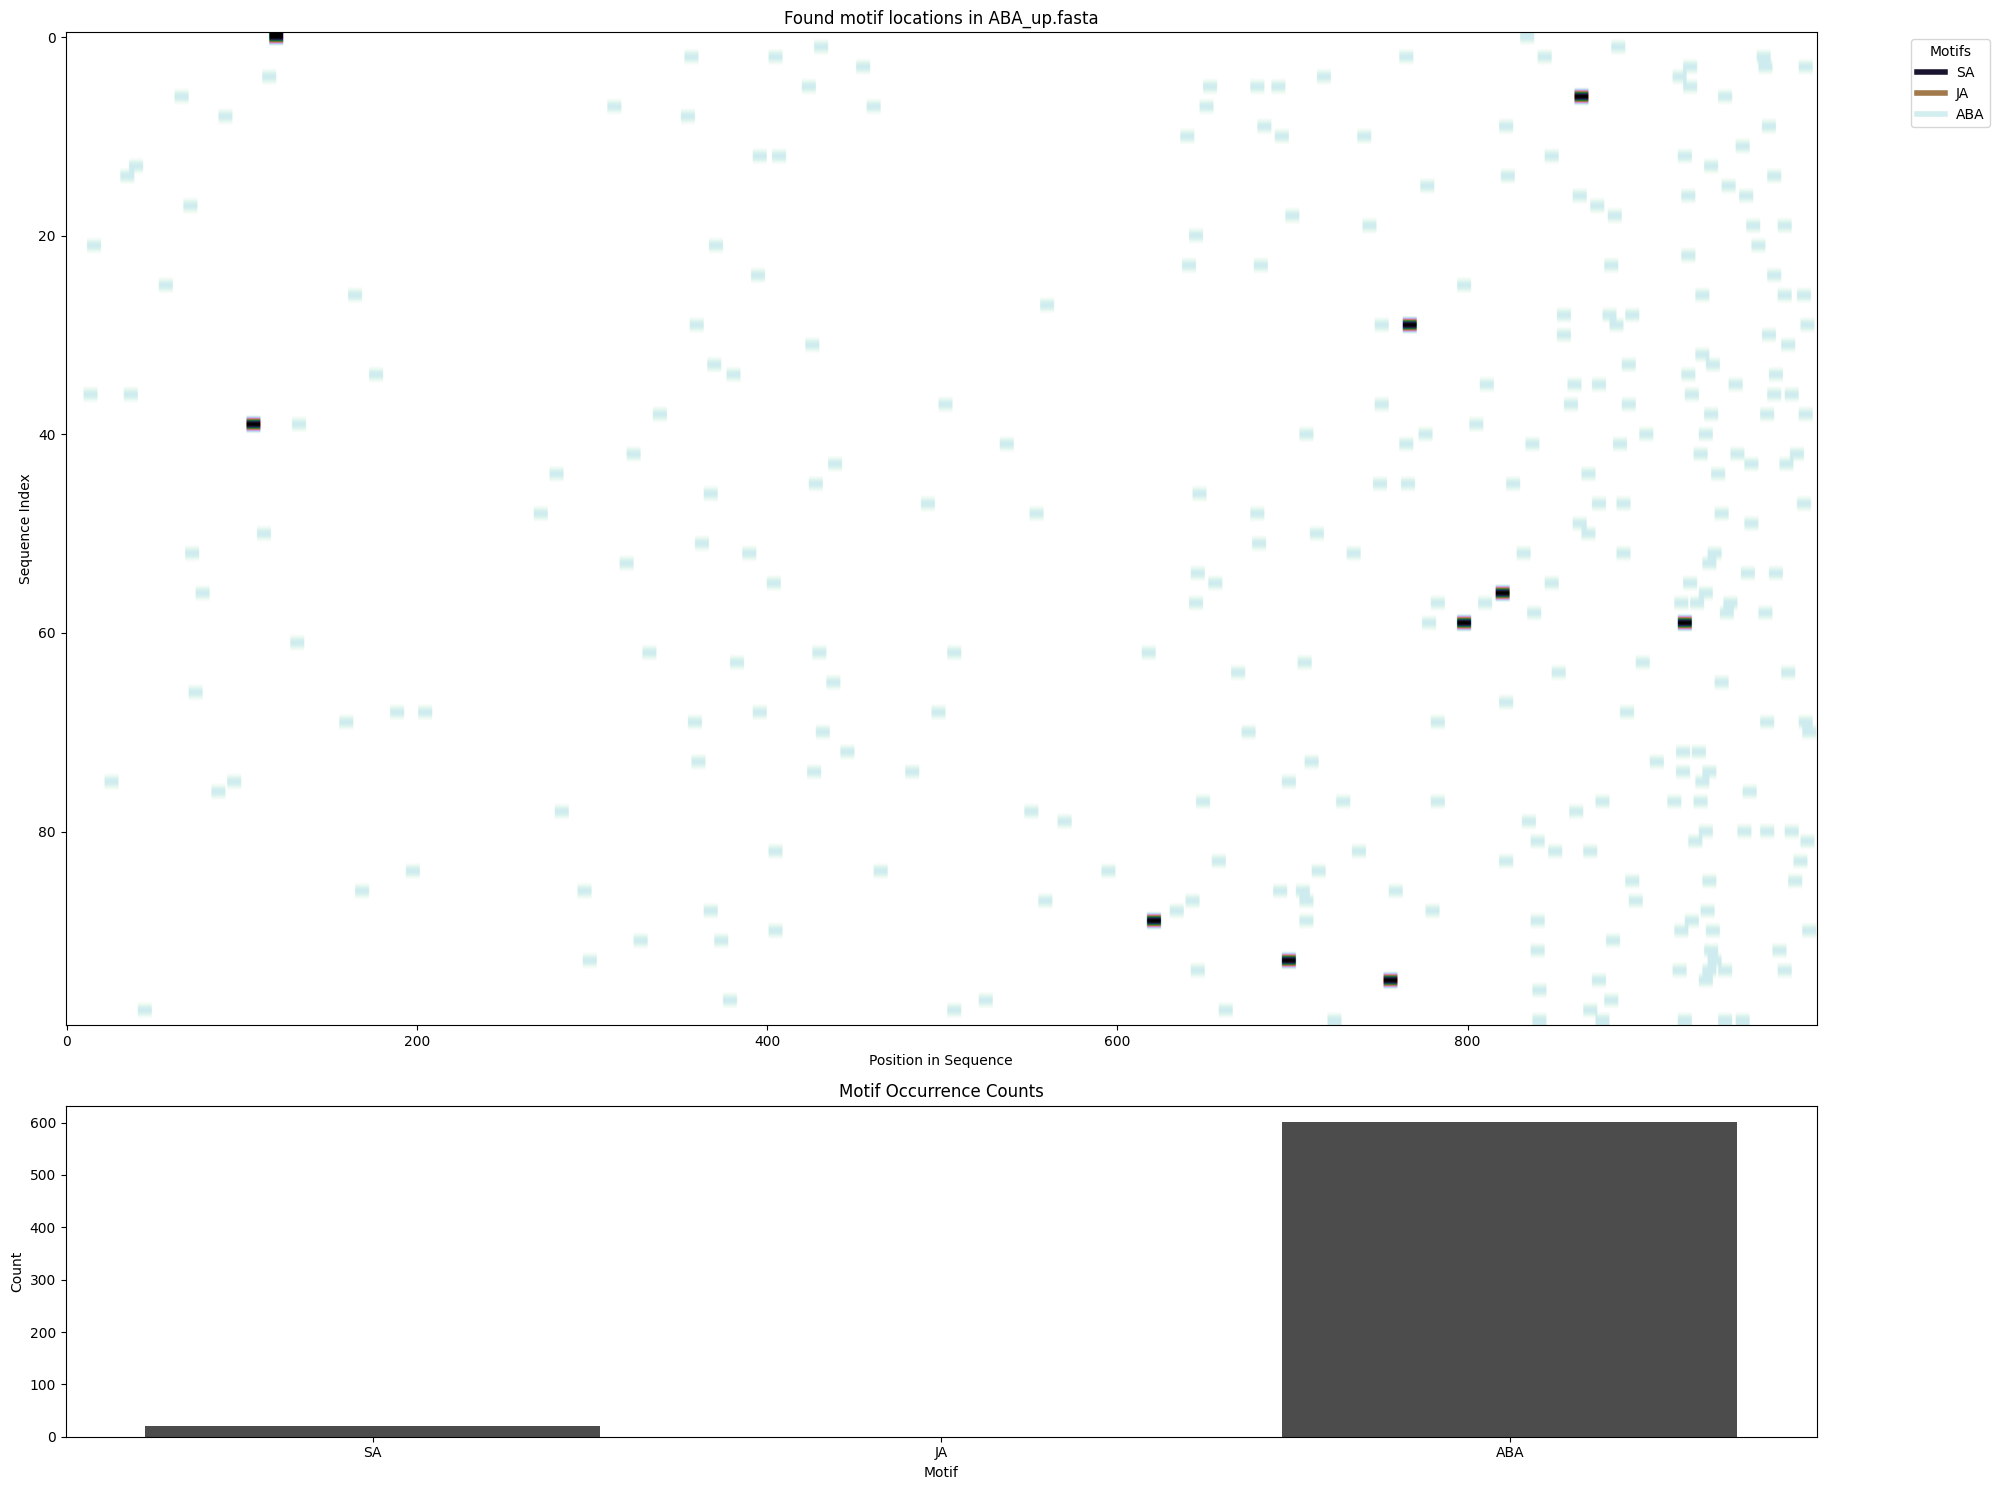

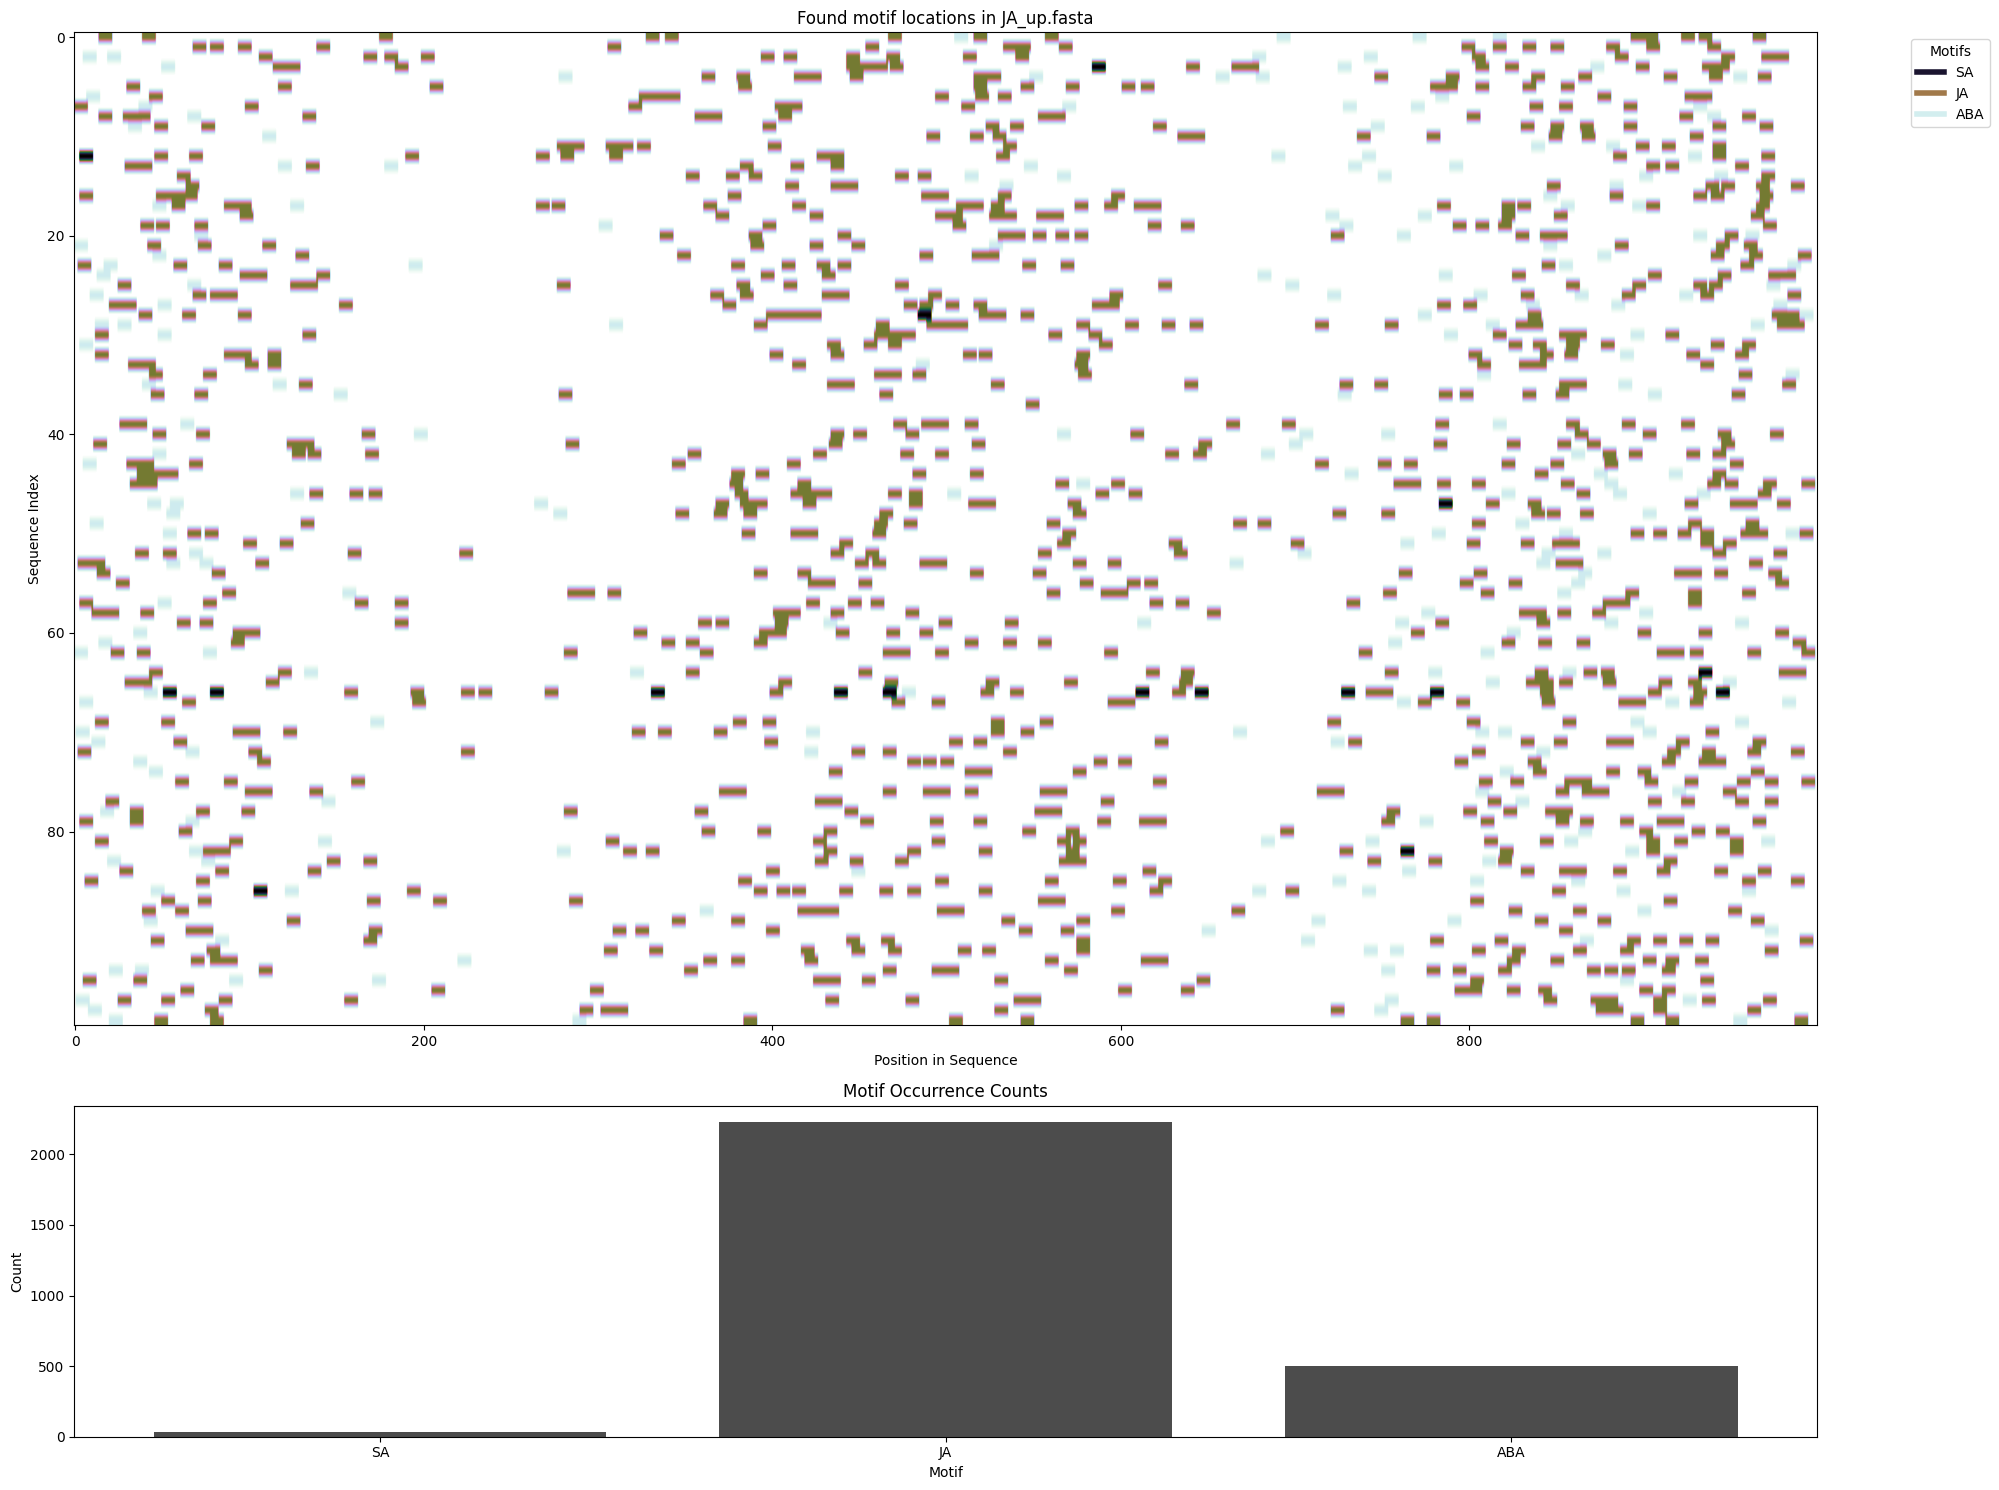

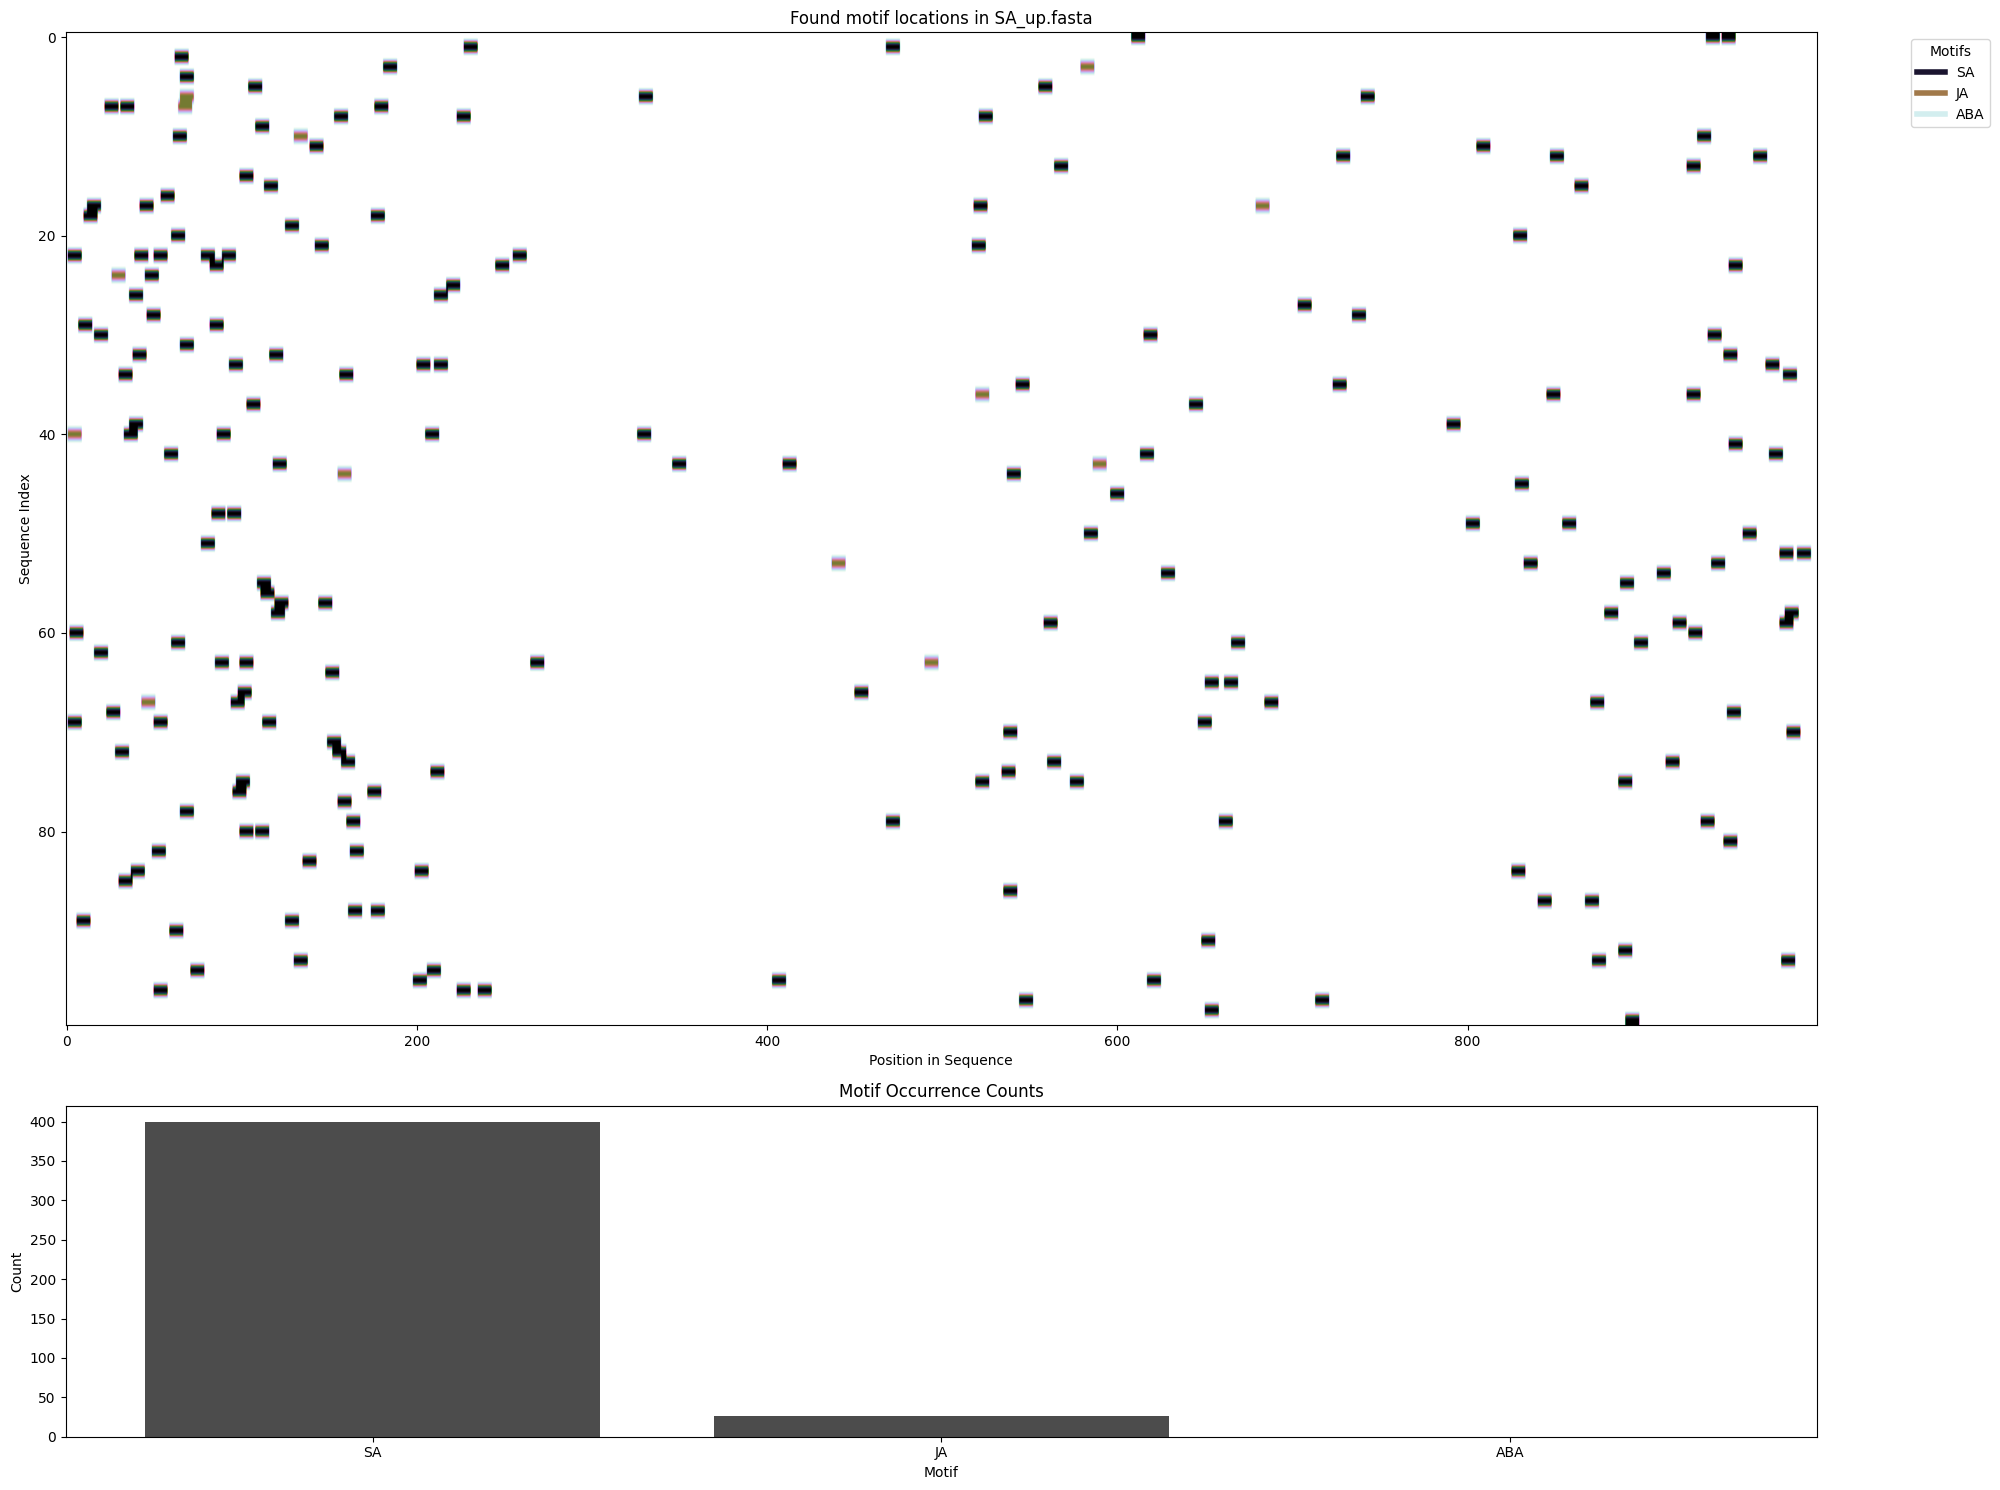

In [11]:
# Example usage
shown_length = 1000
show_total = 1000
shown_sequences = 100
show_rows = shown_sequences * 5
sequence_path = "half_m_rate"
encoded_sequences,fasta_file_names = process_fasta_files(f"generated_sequences/{sequence_path}")
motifs ={"SA":'ACTGGTCA',"JA":'GTCAGTCA',"ABA":'TGGTCAAC'} #jordi mapping
#motifs ={'SA': 'TCTAAGTA', 'JA': 'GCTTGCAC', 'ABA': 'GCTGGAGT'} #random motifs of no interaction model
#motifs ={"SA":'ACGTTGCA',"JA":'TGCATGCA',"ABA":'GTTGCAAC'}
#motifs = {'JA': 'AAAAAAAA', 'ABA': 'GGGGGGGG', 'SA': 'TTTTTTTT'}
#motifs = {'SA': 'ACTGGTCA', 'JA': 'TTCGATCC', 'ABA': 'AAACCAAA'}
#motifs ={"SA":'ACGTTGCAACGT',"JA":'TGCATGCATGCA',"ABA":'GTTGCAACGTTG'}
#motifs ={"SA":'ACTGGTCAACTG',"JA":'GTCAGTCAGTCA',"ABA":'TGGTCAACTGGT'}
save_path = f"motif_plots/{sequence_path}"

if not os.path.exists(save_path):
    os.makedirs(save_path)

for threshold in range(8,9):
    for position in range(0, show_total, shown_length):
        for i in range(len(encoded_sequences)):
            transformed_array = transform_and_insert_zeros(encoded_sequences[i])
            marked_array, legend, motif_counts = mark_motifs(transformed_array[:show_rows,position:position+shown_length], motifs,threshold=threshold,show_full=False,show_legend=True)
            save_path_plot = f"{save_path}/threshold_{threshold}"
            plot_transformed_array(marked_array,fasta_file_names[i], legend,save_path=save_path_plot,motif_counts=motif_counts)
            #plot_transformed_array(marked_array,fasta_file_names[i], legend,motif_counts=motif_counts)

            #plot_transformed_array(marked_array,fasta_file_names[i], legend)